# Importing the libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC

Function for cleaning text

In [2]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

# Load and preprocess the data

In [3]:
train_df = pd.read_csv('./dataset/data.csv', encoding='ISO-8859-1')

# Only keep necessary columns: 'text' and 'sentiment'
train_df = train_df[['text', 'sentiment']]

# Drop any missing values
train_df.dropna(inplace=True)

# Clean the text data
train_df['text'] = train_df['text'].apply(clean_text)

# Encode sentiment labels to numeric values
label_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
train_df['sentiment'] = train_df['sentiment'].map(label_mapping)


# Split the data into training and testing sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df['text'], 
    train_df['sentiment'], 
    test_size=0.2, 
    random_state=42
)

# Define the pipeline with TfidfVectorizer and Logistic Regression

In [5]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 3), max_features=15000)),
    ('svm',SVC()) ,
])

Define parameter grid for hyperparameter tuning

In [6]:
param_grid = {
    'svm__kernel': ['linear'],
    'svm__C': [ 1 ,0.1,0.001], 
}

Perform grid search with cross-validation

In [7]:
grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=15000,
                                                        ngram_range=(1, 3),
                                                        stop_words='english')),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [1, 0.1, 0.001], 'svm__kernel': ['linear']},
             scoring='accuracy')

Best model after tuning

In [8]:
best_model = grid_search.best_estimator_

# Predict sentiment for the test data

In [9]:
y_pred = best_model.predict(X_test)

# Evaluate the model's performance

In [10]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))

Accuracy: 0.70
Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.57      0.64      1572
     neutral       0.64      0.75      0.69      2236
    positive       0.77      0.74      0.75      1688

    accuracy                           0.70      5496
   macro avg       0.71      0.69      0.69      5496
weighted avg       0.70      0.70      0.69      5496



# Confusion Matrix

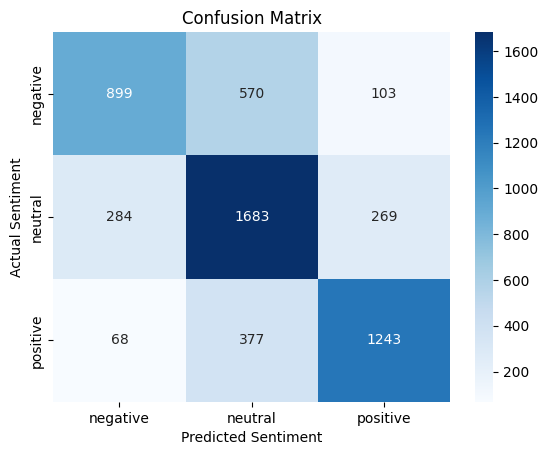

In [11]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])

plt.title('Confusion Matrix')

plt.xlabel('Predicted Sentiment')

plt.ylabel('Actual Sentiment')

plt.show()

# Save the model for future use

In [12]:
with open('./sentiment_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

# Predict sentiment for user input

In [13]:
def predict_sentiment(text):
    # Load the model
    with open('./sentiment_model.pkl', 'rb') as model_file:
        model = pickle.load(model_file)

    # Clean and transform the input text
    cleaned_text = clean_text(text)
    prediction = model.predict([cleaned_text])[0]

    # Map the numeric prediction back to label
    sentiment_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
    return sentiment_mapping[prediction]


Test Case

In [14]:
if __name__ == '__main__':

    user_input = "i am going to kill you"
    predicted_sentiment = predict_sentiment(user_input)
    print(f'The sentiment of the input text is: {predicted_sentiment}')

The sentiment of the input text is: negative
